In [26]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from model import Net

## Train / test dataset and dataloaders

In [22]:
train_data = np.load('train_data.npy', allow_pickle=True)
train_labels = np.load('train_labels.npy', allow_pickle=True)

In [23]:
test_data = np.load('test_data.npy', allow_pickle=True)
test_labels = np.load('test_labels.npy', allow_pickle=True)

In [27]:
labels_map = {}
for i, label in enumerate(train_labels):
    if label not in labels_map:
        labels_map[i] = label

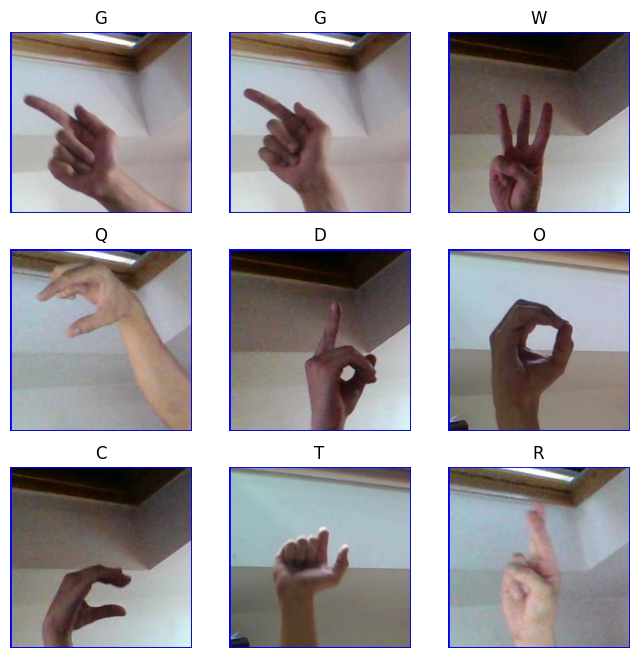

In [28]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_labels[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [25]:
class ASLDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels_non_encoded = labels

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label    

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
])

dataset = ASLDataset(train_data, train_labels, transform=data_transform)  
test_dataset = ASLDataset(test_data, test_labels, transform=data_transform)

In [37]:
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64])


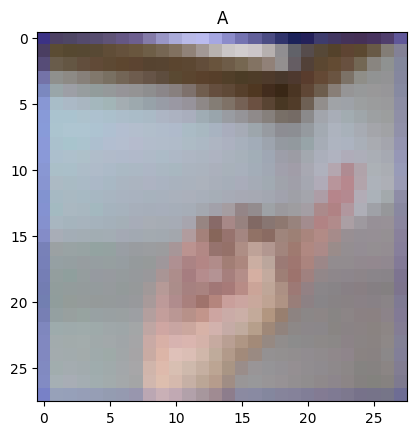

In [36]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute((1, 2, 0))
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.title(labels_map[label.item()])
plt.show()


## Defining and training the model

In [38]:
net = Net(input_shape=[3, 28, 28], num_classes=29, conv_layers=[16, 32], fc_layers=[120, 84])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=29, bias=True)
)

In [39]:
loss_tr, loss_val = [], []
acc_tr, acc_val = [], []

for epoch in range(10):
    
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

            pred = torch.argmax(outputs, axis=1)
            correct += torch.sum(pred == labels).item()
            total += len(labels)

        loss_tr.append(running_loss / total)
        acc_tr.append(correct / total)

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                pred = torch.argmax(outputs, axis=1)
                correct += torch.sum(pred == labels).item()
                total += len(labels)

        loss_val.append(running_loss / total)
        acc_val.append(correct / total)

        print(f"Epoch {epoch+1}")
        print(f"Loss: {loss_tr[-1]}, Val Loss: {loss_val[-1]}")
        print(f"Acc: {acc_tr[-1]}, Val Acc: {acc_val[-1]}")
        print("---------------------------------------------------")

Epoch 1
Loss: 0.012015395874343306, Val Loss: 0.01733673709562455
Acc: 0.7566488024253222, Val Acc: 0.7429885057471264
---------------------------------------------------
Epoch 2
Loss: 0.003532036117868193, Val Loss: 0.002504939251076216
Acc: 0.9244816735872642, Val Acc: 0.9472988505747126
---------------------------------------------------
Epoch 3
Loss: 0.001503075020111633, Val Loss: 0.0020860648749331974
Acc: 0.9679305737151396, Val Acc: 0.9566091954022988
---------------------------------------------------
Epoch 4
Loss: 0.0013228906460554003, Val Loss: 0.000990700570695188
Acc: 0.971666259572695, Val Acc: 0.9791379310344828
---------------------------------------------------
Epoch 5
Loss: 0.0011441096412144797, Val Loss: 0.0007433485782480445
Acc: 0.9756462018132445, Val Acc: 0.9851724137931035
---------------------------------------------------
Epoch 6
Loss: 0.0010352787862204307, Val Loss: 0.0010395152320892647
Acc: 0.9790370551301024, Val Acc: 0.9789080459770115
----------------

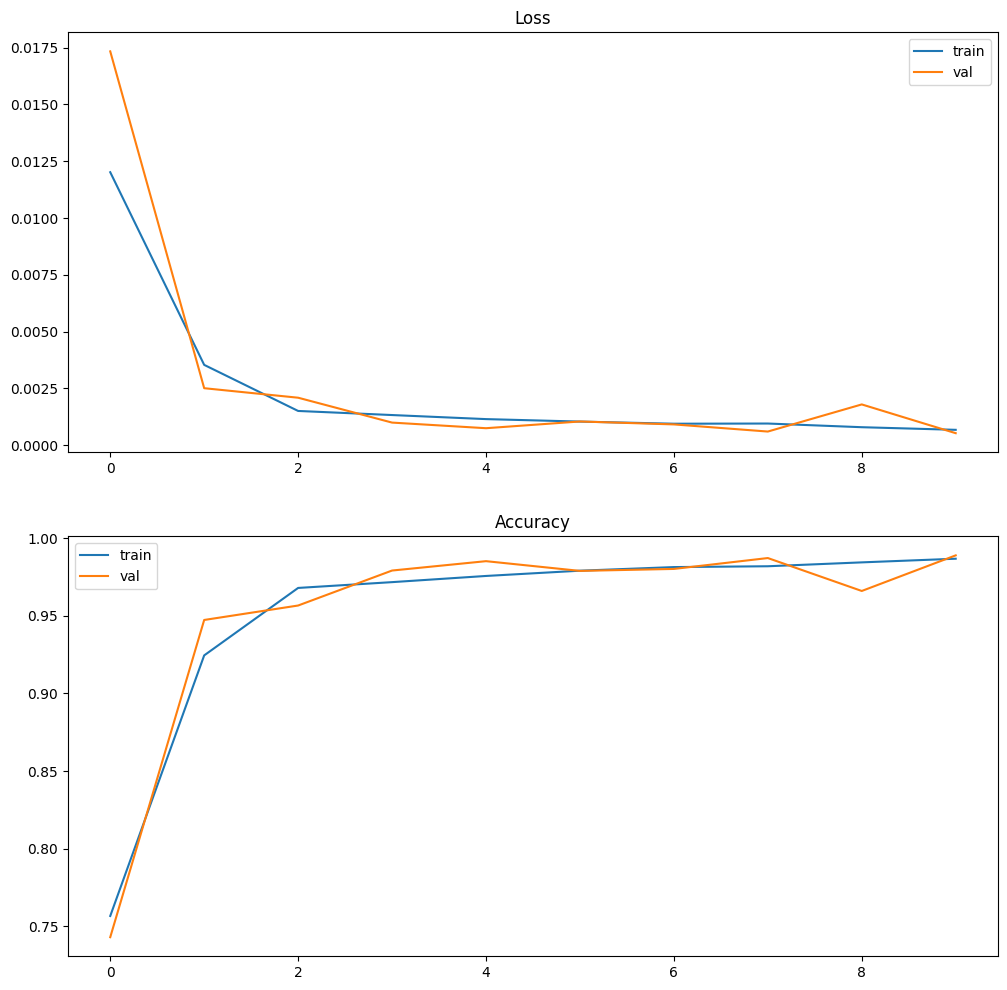

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(loss_tr, label='train')
ax[0].plot(loss_val, label='val')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(acc_tr, label='train')
ax[1].plot(acc_val, label='val')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

Accuracy of the network on the test images: 92.85714285714286%


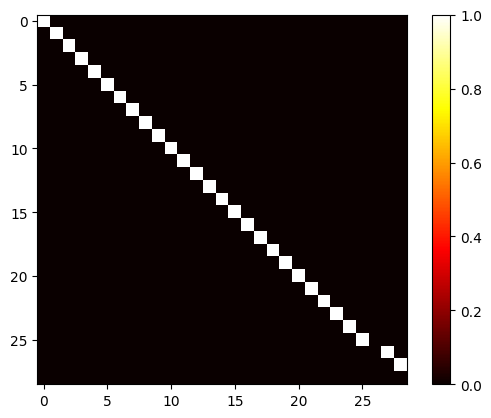

In [42]:
net.eval()
correct = 0
total = 0
preds = []
labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels_batch = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch.to(device)).sum().item()
        preds.extend(predicted.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

cm = confusion_matrix(labels, preds)
plt.imshow(cm, cmap='hot')
plt.colorbar()
plt.show()

torch.save(net.state_dict(), 'model.pth')